In [142]:
#Next daily price close predictions - Predict the target using diferent arguments
#Model Type - Artificial Neural Network 
#09-09-2022
#Version - V1.1 

#Version Implementations:
#Added Market chart fo the whole interval 
#Added Market chart for the Test timeframe 
#Added Yearly and monthly P/L canculations 
#Added Relatory with results 

#Future Implements 
#Plot Return charts to identify the variables that work 
#Plot Comparison to random parameters 
#Plot Price x Return Chart at the same chart 

#Add buy and hold prices to Evaluation 


#Credits:
#This code was brought to you by Luiz Gabriel Bongiolo, only possible because of Leandro Guerra - Check him at: www.outstpokenmarket.com.br / intragram @leandrowar,  





In [143]:
# Carregando as bibliotecas

import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import sklearn.metrics as metrics
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.neural_network import MLPClassifier
from sklearn.neural_network import MLPRegressor
import statsmodels.api as sm
import pandas as pd
import numpy as np
import datetime
import pandas_datareader as pdr
import pickle

In [144]:
# Para remover os warnings
import sys

if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

______________________________________________________

In [145]:
#Import the data

ticker = "BTC-USD"
start = "2017-12-18"
end = datetime.datetime.now()

df1 = pdr.get_data_yahoo(ticker, start, end)
#df1.reset_index(inplace=True)

df1.drop(["Volume", "Adj Close"], axis=1, inplace=True)

df1

,High,Low,Open,Close
Date,,,,
2017-12-18,19371.000000,18355.900391,19106.400391,19114.199219
2017-12-19,19177.800781,17275.400391,19118.300781,17776.699219
2017-12-20,17934.699219,16077.700195,17760.300781,16624.599609
2017-12-21,17567.699219,15342.700195,16642.400391,15802.900391
2017-12-22,15943.400391,11833.000000,15898.000000,13831.799805
...,...,...,...,...
2022-09-15,20318.166016,19636.734375,20242.289062,19701.210938
2022-09-16,19870.628906,19400.076172,19704.005859,19772.583984
2022-09-17,20162.531250,19777.033203,19777.033203,20127.576172


In [146]:
# Carregando a base de dados e fazendo os checks iniciais

# Muda o diretorio de trabalho
#import os
#os.chdir("/home/semrival/Documents/Python Programs /Outspoken Market/Outspoken Market Lives/13 - Redes Neurais in Quant Finance/")

#df1 = pd.read_csv("mini_indice_D1.csv", sep = ";")

#df1.shape[0]

______________________________________________________

In [147]:
# If you need to fix the Index to work with later on with dates 

#df1["Data"] = pd.to_datetime(df1["Data"]).dt.normalize()

#df1 = df1.set_index("Data")

#df1

In [148]:
df1.describe()

,High,Low,Open,Close
count,1737.000000,1737.000000,1737.000000,1737.000000
mean,20943.575773,19838.603817,20428.004734,20425.576029
std,17867.843006,16890.307711,17415.014716,17410.366547
min,3275.377930,3191.303467,3236.274658,3236.761719
25%,7680.430176,7365.985352,7508.902344,7514.671875
50%,10777.696289,10234.576172,10535.492188,10538.459961
75%,36436.421875,33570.476562,35502.941406,35501.953125
max,68789.625000,66382.062500,67549.734375,67566.828125


______________________________________________________

In [149]:
# Construcao dos alvos

periodos = 1

# lag de X periodos
df1["Lag1"] = df1["Close"].shift(-periodos)

# Alvo 1 - Retorno
df1["Retorno"] = df1["Close"].pct_change(periodos)
df1["Alvo1"] = df1["Retorno"].shift(-periodos)

# Variaçao em Pontos do alvo
df1["Pontos"] = (df1["Close"] - df1["Close"].shift(1))
df1["Pontos"] = df1["Pontos"].shift(-periodos)

In [150]:
df1["Retorno"].describe()

count    1736.000000
mean        0.000807
std         0.039522
min        -0.371695
25%        -0.016209
50%         0.001215
75%         0.017739
max         0.187465
Name: Retorno, dtype: float64

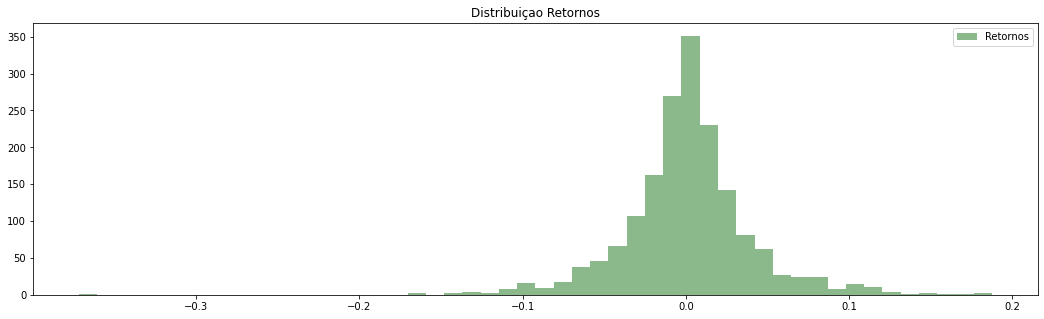

In [151]:
plt.figure(figsize = (18,5))
plt.hist(df1["Retorno"], bins = 50
        , alpha = 0.45
        , histtype = "stepfilled"
        , color = "darkgreen"
        , edgecolor = "none"
        , label = "Retornos");

plt.legend()
plt.title("Distribuiçao Retornos");

In [152]:
# Criacao do alvo
df1["Alvo_Bin"] = np.where(df1['Alvo1'] > df1["Retorno"].describe()[6]/2 , 1
                           , np.where(df1['Alvo1'] < df1["Retorno"].describe()[4]/2, -1, 0))

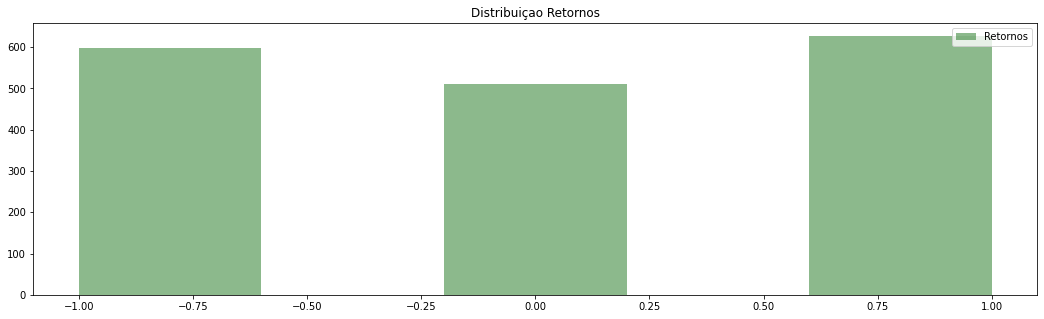

In [153]:
plt.figure(figsize = (18,5))
plt.hist(df1["Alvo_Bin"], bins = 5
        , alpha = 0.45
        , histtype = "stepfilled"
        , color = "darkgreen"
        , edgecolor = "none"
        , label = "Retornos");

plt.legend()
plt.title("Distribuiçao Retornos");

In [154]:
# Construçao das Variaveis

# Desvio Padrao de 5 dias
df1["std5"] = df1["Retorno"].rolling(5).std()

# Desvio Padrao de 10 dias
df1["std10"] = df1["Retorno"].rolling(10).std()

# Desvio Padrao de 15 dias
df1["std15"] = df1["Retorno"].rolling(15).std()

# Proporçao do corpo do candle em relacao ao range do dia
df1["prop"] = (df1["Close"]-df1["Open"])/(df1["High"]-df1["Low"])

# Direçao do dia atual
df1["dir_D"] = np.where(df1['Close'] > df1['Open'] , '1', '0')

# Direçao D-1
df1["dir_D-1"] = df1["dir_D"].shift(1)

# Direçao D-2
df1["dir_D-2"] = df1["dir_D"].shift(2)

# Direçao D-3
df1["dir_D-3"] = df1["dir_D"].shift(3)

# Media Movel de 15 dias std5
df1["mm_std5"] = df1["std5"].rolling(15).mean()

# Media Movel de 15 dias std5
df1["mm_std10"] = df1["std10"].rolling(15).mean()

# Media Movel de 15 dias std5
df1["mm_std15"] = df1["std15"].rolling(15).mean()

# RSL std5
df1["RSL_std5"] = (df1["std5"]/df1["std5"].rolling(15).mean())-1   #RSL indicador, pega a distancia do preco, nesse caso para a para a média movel 

# RSL std10
df1["RSL_std10"] = (df1["std10"]/df1["std10"].rolling(15).mean())-1

# RSL std15
df1["RSL_std15"] = (df1["std15"]/df1["std15"].rolling(15).mean())-1

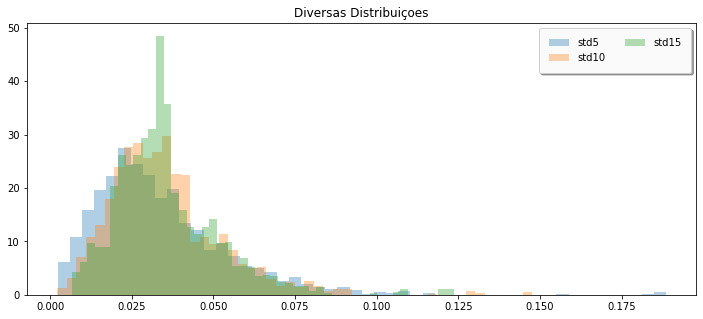

In [155]:
plt.figure(figsize = (12,5))
config = dict(histtype = 'stepfilled', alpha = 0.35, density = True, bins = 50)

plt.hist(df1["std5"], **config, label = "std5")
plt.hist(df1["std10"], **config, label = "std10")
plt.hist(df1["std15"], **config, label = "std15")

# Formataçao da legenda - Valida para qualquer tipo de grafico
plt.legend(loc = "upper right"
           , frameon = True
           , ncol = 2 
           , fancybox = True
           , framealpha = 0.95
           , shadow = True
           , borderpad = 1)
plt.title("Diversas Distribuiçoes");

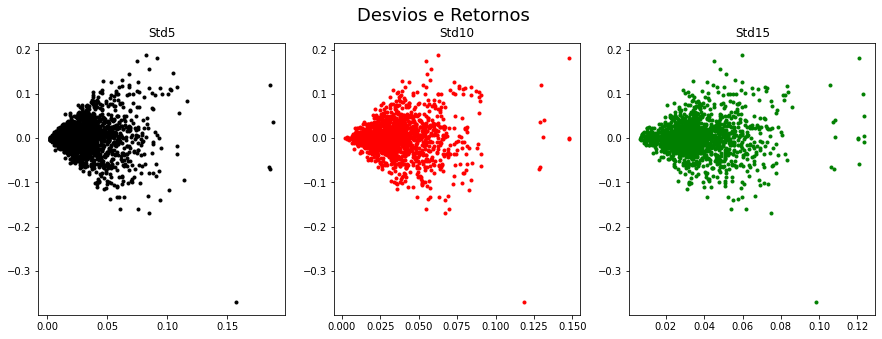

In [156]:
fig, axs = plt.subplots(1,3,figsize=(15, 5));
fig.suptitle("Desvios e Retornos", fontsize = 18);
axs[0].set_title('Std5')
axs[1].set_title('Std10')
axs[2].set_title('Std15')
axs[0].plot(df1["std5"], df1["Retorno"], ".", color = "black", label = "aleatorio")
axs[1].plot(df1["std10"], df1["Retorno"], ".", color = "red", label = "aleatorio")
axs[2].plot(df1["std15"], df1["Retorno"], ".", color = "green", label = "aleatorio");

In [157]:
#This will help the model to understand better the difference between 0 and 1, the 

In [158]:
pd.crosstab(pd.qcut(df1["RSL_std5"], 10, labels = False), df1["Alvo_Bin"])/df1.shape[0]*100

Alvo_Bin,-1,0,1
RSL_std5,,,
0.0,3.339090,3.339090,3.223949
1.0,3.626943,2.936097,3.339090
2.0,2.878526,2.993667,4.029937
3.0,4.317789,2.705815,2.820956
4.0,2.763385,3.223949,3.914796
5.0,3.051238,2.360391,4.490501
6.0,4.202648,2.475533,3.166379
7.0,3.108808,2.993667,3.799655
8.0,3.223949,3.223949,3.454231


In [159]:
# Filtrando os valores missing

df1_filtrado = df1.dropna(axis = 0) 

df1_filtrado= df1_filtrado.drop(["std5","std10","std15","mm_std5","mm_std10","mm_std15"], axis = 1) #Elimina essa informaçao pois ela ja esta no RSL 

In [160]:
df1_filtrado["RSL_std5"] = pd.qcut(df1_filtrado["RSL_std5"], 10, labels = False)
df1_filtrado["RSL_std10"] = pd.qcut(df1_filtrado["RSL_std10"], 10, labels = False)
df1_filtrado["RSL_std15"] = pd.qcut(df1_filtrado["RSL_std15"], 10, labels = False)

In [161]:
df1_filtrado.head()

,High,Low,Open,Close,Lag1,Retorno,Alvo1,Pontos,Alvo_Bin,prop,dir_D,dir_D-1,dir_D-2,dir_D-3,RSL_std5,RSL_std10,RSL_std15
Date,,,,,,,,,,,,,,,,,
2018-01-16,13843.099609,10194.900391,13836.099609,11490.500000,11188.599609,-0.168548,-0.026274,-301.900391,-1,-0.642947,0,1,0,1,7,4,5
2018-01-17,11678.000000,9402.290039,11431.099609,11188.599609,11474.900391,-0.026274,0.025589,286.300781,1,-0.106560,0,0,1,0,6,4,4
2018-01-18,12107.299805,10942.500000,11198.799805,11474.900391,11607.400391,0.025589,0.011547,132.500000,1,0.237037,1,0,0,1,6,4,4
2018-01-19,11992.799805,11172.099609,11429.799805,11607.400391,12899.200195,0.011547,0.111291,1291.799805,1,0.216401,1,1,0,0,7,5,4
2018-01-20,13103.000000,11656.200195,11656.200195,12899.200195,11600.099609,0.111291,-0.100712,-1299.100586,-1,0.859138,1,1,1,0,8,7,4


______________________________________________________

### Passo 5 - Preparaçao da base para treinamento e teste

In [162]:
# Separando os dados entre treinamento e teste

# Vamos treinar o modelo de 2005 à 2010
start_train = start
end_train = "2021-1-01"

# Vamos testar o modelo de 2011 à 2020
start_test = "2021-01-02"
end_test = datetime.datetime.now()

df1_train1 = df1_filtrado[start_train : end_train]

df1_test1 = df1_filtrado[start_test : end_test]

In [163]:
df1_filtrado.columns

Index(['High', 'Low', 'Open', 'Close', 'Lag1', 'Retorno', 'Alvo1', 'Pontos',
       'Alvo_Bin', 'prop', 'dir_D', 'dir_D-1', 'dir_D-2', 'dir_D-3',
       'RSL_std5', 'RSL_std10', 'RSL_std15'],
      dtype='object')

In [164]:
# Separando os dados com as variaveis em x e o alvo em y
 
x_train1 = df1_train1.iloc[:, 9:16]
y_train1 = df1_train1['Alvo_Bin'].values.reshape(-1, 1)

x_test1 = df1_test1.iloc[:, 9:16]
y_test1 = df1_test1['Alvo_Bin'].values.reshape(-1, 1)

______________________________________________________

### Passo 6 - Treinamento do modelo

In [165]:
# Training the model - Time to fry

mlp1 = MLPClassifier(hidden_layer_sizes = (100,500,100), max_iter = 500,
                    solver = "sgd", verbose = 10, tol = 1e-8, random_state = 42,
                    learning_rate_init = .00005, learning_rate = "adaptive", activation = "tanh")

mlp1.fit(x_train1, y_train1) # essa é a linha que treina o modelo!!!!

Iteration 1, loss = 1.29850479
Iteration 2, loss = 1.27937778
Iteration 3, loss = 1.25350166
Iteration 4, loss = 1.22682408
Iteration 5, loss = 1.20248462
Iteration 6, loss = 1.18128343
Iteration 7, loss = 1.16349259
Iteration 8, loss = 1.14910969
Iteration 9, loss = 1.13809215
Iteration 10, loss = 1.12888525
Iteration 11, loss = 1.12161405
Iteration 12, loss = 1.11703355
Iteration 13, loss = 1.11328541
Iteration 14, loss = 1.11044890
Iteration 15, loss = 1.10834099
Iteration 16, loss = 1.10686752
Iteration 17, loss = 1.10569116
Iteration 18, loss = 1.10472809
Iteration 19, loss = 1.10424037
Iteration 20, loss = 1.10357869
Iteration 21, loss = 1.10325646
Iteration 22, loss = 1.10292582
Iteration 23, loss = 1.10265374
Iteration 24, loss = 1.10237984
Iteration 25, loss = 1.10227689
Iteration 26, loss = 1.10206733
Iteration 27, loss = 1.10191126
Iteration 28, loss = 1.10179816
Iteration 29, loss = 1.10160817
Iteration 30, loss = 1.10146313
Iteration 31, loss = 1.10131315
Iteration 32, los

MLPClassifier(activation='tanh', hidden_layer_sizes=(100, 500, 100),
              learning_rate='adaptive', learning_rate_init=5e-05, max_iter=500,
              random_state=42, solver='sgd', tol=1e-08, verbose=10)

In [166]:
#(100, 500, 100), max_iter = 500,

In [167]:
# Prediçoes para o treinamento e teste

y_pred_train1 = mlp1.predict(x_train1)
y_pred_test1 = mlp1.predict(x_test1)

______________________________________________________

In [168]:
# Treinamento

print(confusion_matrix(y_train1, y_pred_train1))
print()
print("--------------------------------------------------------------------------------")
print()
print(classification_report(y_train1, y_pred_train1))

[[ 40  62 238]
 [ 36  88 226]
 [ 30  64 298]]

--------------------------------------------------------------------------------

              precision    recall  f1-score   support

          -1       0.38      0.12      0.18       340
           0       0.41      0.25      0.31       350
           1       0.39      0.76      0.52       392

    accuracy                           0.39      1082
   macro avg       0.39      0.38      0.34      1082
weighted avg       0.39      0.39      0.34      1082



In [169]:
# Teste

print(confusion_matrix(y_test1, y_pred_test1))
print()
print("--------------------------------------------------------------------------------")
print()
print(classification_report(y_test1, y_pred_test1))

[[ 22  46 176]
 [ 11  24 121]
 [ 25  38 162]]

--------------------------------------------------------------------------------

              precision    recall  f1-score   support

          -1       0.38      0.09      0.15       244
           0       0.22      0.15      0.18       156
           1       0.35      0.72      0.47       225

    accuracy                           0.33       625
   macro avg       0.32      0.32      0.27       625
weighted avg       0.33      0.33      0.27       625



In [170]:
# Calculando a performance - para toda a base

y_pred_all = mlp1.predict(df1_filtrado.iloc[:, 9:16])

In [171]:
df1_filtrado.loc[: , "Previsto"] = y_pred_all
df1_filtrado.loc[: , "Retorno_Modelo"] = df1_filtrado.loc[: , "Previsto"]*df1_filtrado["Alvo1"]

#Simulando um stop de X%

stop = 0.01
df1_filtrado.loc[: , "Retorno_Modelo"] = np.where(df1_filtrado.loc[: , 'Retorno_Modelo'] < -stop  #Esse stop nao considera o tick a tick (se bater o stop e voltar a subir) 
                                               , -stop, df1_filtrado.loc[: , 'Retorno_Modelo'])

df1_filtrado.loc[: , "Retorno_Modelo_Acumulado"] = df1_filtrado["Retorno_Modelo"].cumsum()

In [172]:
df1_filtrado.loc[: , "Retorno_Modelo_Acumulado"].tail()

Date
2022-09-14    14.585572
2022-09-15    14.589195
2022-09-16    14.579195
2022-09-17    14.569195
2022-09-18    14.574954
Name: Retorno_Modelo_Acumulado, dtype: float64

In [173]:
# Para fazer um conditional plot

df1_filtrado.index.name = "Date"
df1_filtrado.reset_index(inplace = True)

df1_filtrado["Date"] = pd.to_datetime(df1_filtrado["Date"])

df1_filtrado["train_test"] = np.where(df1_filtrado["Date"] > end_train, 1, -1)

In [174]:
df1_filtrado.head()

,Date,High,Low,Open,Close,Lag1,Retorno,Alvo1,Pontos,Alvo_Bin,...,dir_D-1,dir_D-2,dir_D-3,RSL_std5,RSL_std10,RSL_std15,Previsto,Retorno_Modelo,Retorno_Modelo_Acumulado,train_test
0,2018-01-16,13843.099609,10194.900391,13836.099609,11490.500000,11188.599609,-0.168548,-0.026274,-301.900391,-1,...,1,0,1,7,4,5,1,-0.010000,-0.010000,-1
1,2018-01-17,11678.000000,9402.290039,11431.099609,11188.599609,11474.900391,-0.026274,0.025589,286.300781,1,...,0,1,0,6,4,4,1,0.025589,0.015589,-1
2,2018-01-18,12107.299805,10942.500000,11198.799805,11474.900391,11607.400391,0.025589,0.011547,132.500000,1,...,0,0,1,6,4,4,1,0.011547,0.027136,-1
3,2018-01-19,11992.799805,11172.099609,11429.799805,11607.400391,12899.200195,0.011547,0.111291,1291.799805,1,...,1,0,0,7,5,4,1,0.111291,0.138427,-1
4,2018-01-20,13103.000000,11656.200195,11656.200195,12899.200195,11600.099609,0.111291,-0.100712,-1299.100586,-1,...,1,1,0,8,7,4,-1,0.100712,0.239138,-1


In [175]:
base_agregada = df1_filtrado.resample("M", on = "Date").sum()

base_agregada.loc[: , "Retorno_Modelo_Acumulado"] = base_agregada["Retorno_Modelo"].cumsum()*100

""


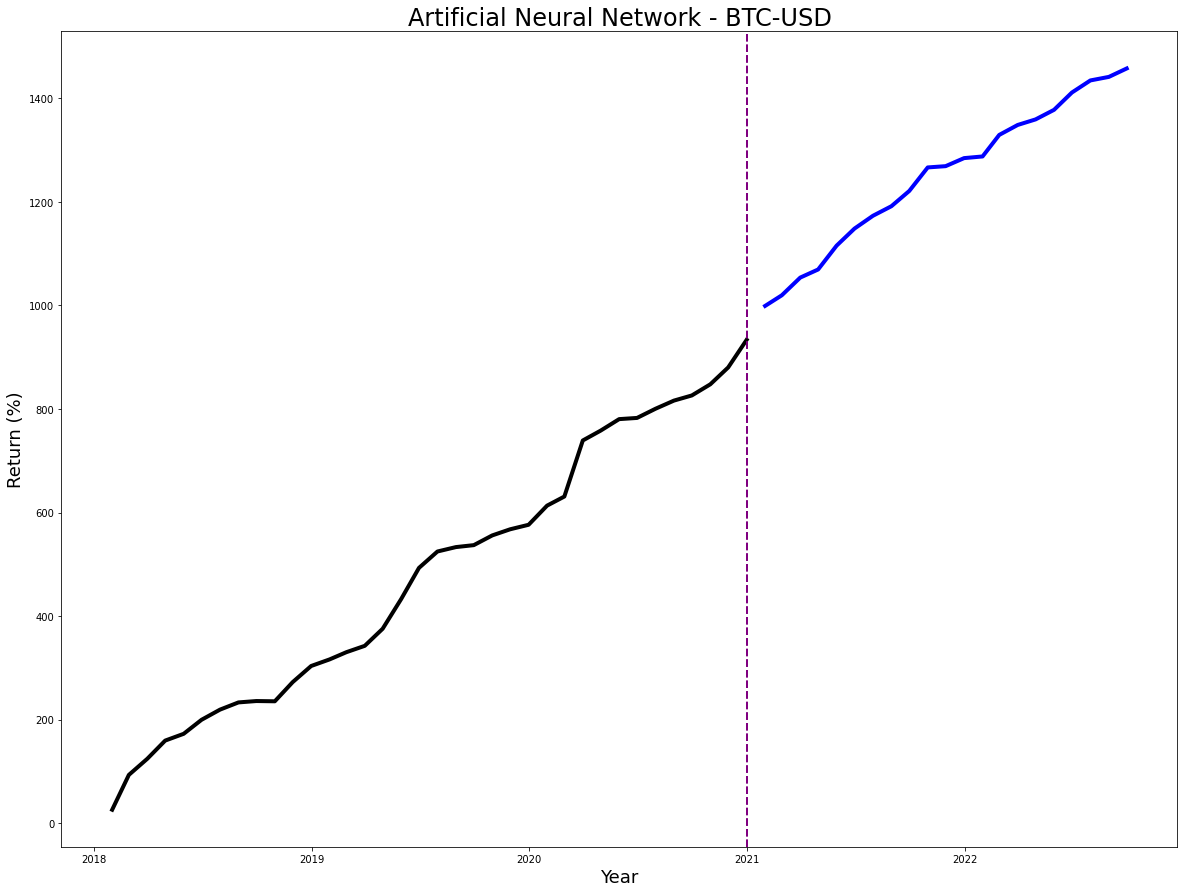

In [176]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

# Plota o grafico
fig, ax = plt.subplots(figsize = (20,15))

def grafico(group):
    color = "black" if (group["train_test"] < 0).all() else "blue"
    lw = 4.0
    ax.plot(group.index, group.Retorno_Modelo_Acumulado, c=color, linewidth=lw)
    plt.xlabel("Year"
           , fontsize = 18);
    plt.ylabel("Return (%)"
           , fontsize = 18);
    plt.title("Artificial Neural Network - "+ str(ticker) , fontsize = 24)
    plt.axvline( x = end_train, color='purple', linestyle = "--", lw = 2)
    setup = dict(size = 16, color = "darkgreen")
    setup2 = dict(size = 14, color = "black")
    #plt.text("2010-01-01", 1500, "Treinamento: 2008-2016", **setup)
    #plt.text("2018-01-01", 1500, "Teste: 2016-2022", **setup)
    #plt.text("2015-01-01", 6800, "Retorno total: +587%", **setup2)
    #plt.text("2015-01-01", 6800, "Retorno teste: +218%", **setup2)
    #plt.text("2017-01-01", 6800, "Luiz Gabriel Bongiolo", **setup2)

base_agregada.groupby((base_agregada["train_test"].shift() * base_agregada["train_test"] < 0).cumsum()).apply(grafico)


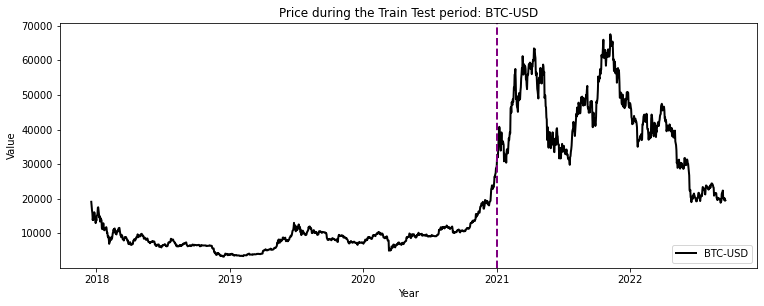

In [177]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

# Plotting the real asset price history

plt.figure(figsize=(12.5,4.5))
plt.plot(df1["Close"], label = ticker, linewidth = 2, color = "black")
plt.title("Price during the Train Test period: "+str(ticker))
plt.xlabel("Year")
plt.ylabel("Value")
plt.axvline( x = end_train, color='purple', linestyle = "--", lw = 2)
plt.legend(loc = "lower right")
plt.show()

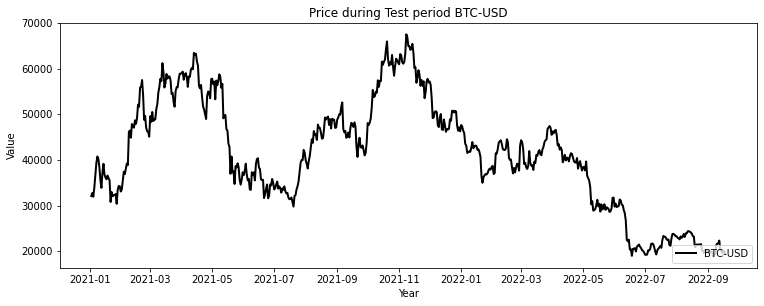

In [178]:
# Plotting the real asset price during the test time interval 

plt.figure(figsize=(12.5,4.5))
plt.plot(df1_test1["Close"], label = ticker, linewidth = 2, color = "black")
plt.title("Price during Test period "+ str(ticker))
plt.xlabel("Year")
plt.ylabel("Value")
plt.legend(loc = "lower right")
plt.show()

In [179]:
# Calculando a performance - para a base de teste

df1_test1.loc[: , "Previsto"] = y_pred_test1
df1_test1.loc[: , "Retorno_Modelo"] = df1_test1.loc[: , "Previsto"]*df1_test1["Alvo1"]

#Simulando um stop de 3%

stop = 0.01
df1_test1.loc[: , "Retorno_Modelo"] = np.where(df1_test1.loc[: , 'Retorno_Modelo'] < -stop       #Stop is not literal, it doesnt consider days when the stop hit and went in your direction 
                                               , -stop, df1_test1.loc[: , 'Retorno_Modelo'])

df1_test1.loc[: , "Retorno_Modelo_Acumulado"] = df1_test1["Retorno_Modelo"].cumsum()

In [180]:
df1_test1.loc[: , "Retorno_Modelo_Acumulado"].tail()

Date
2022-09-14    5.157074
2022-09-15    5.160696
2022-09-16    5.150696
2022-09-17    5.140696
2022-09-18    5.146455
Name: Retorno_Modelo_Acumulado, dtype: float64

In [181]:
#df1_test1.index.name = "Date"
df1_test1.reset_index(inplace = True)

df1_test1["Date"] = pd.to_datetime(df1_test1["Date"])

teste_agregado = df1_test1.resample("M", on = "Date").sum()

teste_agregado.loc[: , "Retorno_Modelo_Acumulado"] = teste_agregado["Retorno_Modelo"].cumsum()*100

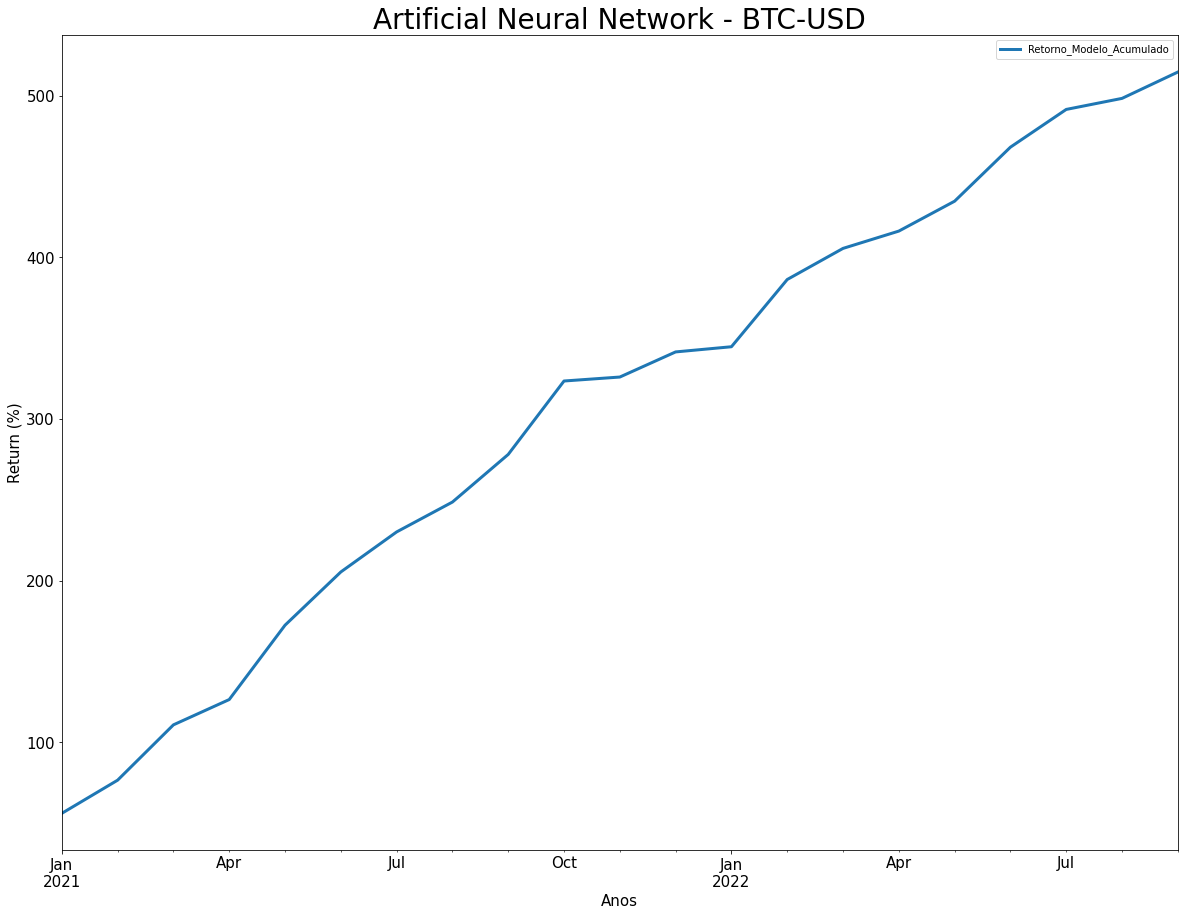

In [182]:
teste_agregado["Retorno_Modelo_Acumulado"].plot(figsize=(20,15)
                                     , linewidth = 3
                                     , fontsize = 15)
plt.xlabel("Anos"
           , fontsize = 15);
plt.ylabel("Return (%)"
           , fontsize = 15);
plt.title("Artificial Neural Network - "+str(ticker), fontsize = 28)
plt.legend()
plt.show()

In [183]:
summary = df1_filtrado.copy()
summary["Date"] = pd.to_datetime(summary["Date"], format = "%Y-%m")

summary = summary.groupby([summary["Date"].dt.year]).agg({"Retorno_Modelo": sum})

summary.index = summary.index.set_names(["Ano"])

summary*100

,Retorno_Modelo
Ano,
2018,303.658726
2019,272.695832
2020,357.122733
2021,350.901261
2022,173.116819


In [184]:
summary_mes = df1_filtrado.copy()
summary_mes["Date"] = pd.to_datetime(summary_mes["Date"], format = "%Y-%m")

summary_mes = summary_mes.groupby([summary_mes["Date"].dt.year, summary_mes["Date"].dt.month]).agg({"Retorno_Modelo": sum})

summary_mes.index = summary_mes.index.set_names(["Year", "Month"])

summary_mes*100

#summary_mes.tail(50)

Retorno_Modelo
Year Month                
2018 1           26.089878
     2           67.284875
     3           31.197818
     4           35.047890
     5           13.083172
     6           27.053766
     7           19.644196
     8           13.934229
     9            2.653188
     10          -0.487237
     11          37.014984
     12          31.141967
2019 1           12.747024
     2           13.859263
     3           12.333301
     4           32.938554
     5           57.210515
     6           60.352425
     7           31.641543
     8            8.520827
     9            3.774788
     10          18.782428
     11          11.806944
     12           8.728218
2020 1           36.951428
     2           17.574953
     3          108.268633
     4           19.043774
     5           22.182097
     6            2.287462
     7           17.725321
     8           15.767696
     9            9.921226
     10          21.503915
     11          32.579233
     12          53.316996
2021 1           65.473478
     2           20.518609
     3           34.220259
     4           15.648892
     5           45.991094
     6           32.932507
     7           24.760524
     8           18.481581
     9           29.468129
     10          45.415324
     11           2.451686
     12          15.539178
2022 1            3.201840
     2           41.591126
     3           19.244988
     4           10.705672
     5           18.497169
     6           33.415228
     7           23.345419
     8            6.832463
     9           16.282915

In [185]:
print("--- BONGIOLO: Artificial Neural Network Results for: " + str(ticker) +" - ("+ str(start) + " - Today) ---")
print("")
print("Train: " + str(start_train)+" - "+str(end_train))
print("Test: " + str(start_test) +" - Today" )
print("Stop: "+ str(stop*100)+"%" + " - Operational cost not included")
print("---------------------------------------------------")
print("")
print("Worst Monthly Return:     {} %".format(round(summary_mes["Retorno_Modelo"].min(), 3)*100))
print("Best Monthly Return:       {} %".format(int(round(summary_mes["Retorno_Modelo"].max(), 3)*100)))  #remove int to precise results 
print("Monthly Average Return:    {} %".format(round(summary_mes["Retorno_Modelo"].mean(), 2)*100))
print("---------------------------------")
print("Worst Annual Return:      {} %".format(round(summary["Retorno_Modelo"].min(), 3)*100))
print("Best Annual Return:        {} %".format(round(summary["Retorno_Modelo"].max(), 3)*100))
print("Annual Average Return:     {} %".format(int(round(summary["Retorno_Modelo"].mean(), 2)*100)))
print("---------------------------------")
print("# Negative Years:        {}".format((summary["Retorno_Modelo"] < 0).sum()))
print("# Positive Years :       {}".format((summary["Retorno_Modelo"] > 0).sum()))
print("---------------------------------")
print("# Negative Months :      {}".format((summary_mes["Retorno_Modelo"] < 0).sum()))
print("# Positive Months:       {}".format((summary_mes["Retorno_Modelo"] > 0).sum()))
print("---------------------------------")
print("# Total P/L (simple):   {} %".format(int(round(summary_mes["Retorno_Modelo"].sum(), 3)*100)))
print("# Test  P/L (simple):   {} %".format(int(round(teste_agregado["Retorno_Modelo"].sum(), 3)*100)))


--- BONGIOLO: Artificial Neural Network Results for: BTC-USD - (2017-12-18 - Today) ---

Train: 2017-12-18 - 2021-1-01
Test: 2021-01-02 - Today
Stop: 1.0% - Operational cost not included
---------------------------------------------------

Worst Monthly Return:     -0.5 %
Best Monthly Return:       108 %
Monthly Average Return:    26.0 %
---------------------------------
Worst Annual Return:      173.10000000000002 %
Best Annual Return:        357.1 %
Annual Average Return:     291 %
---------------------------------
# Negative Years:        0
# Positive Years :       5
---------------------------------
# Negative Months :      1
# Positive Months:       56
---------------------------------
# Total P/L (simple):   1457 %
# Test  P/L (simple):   514 %


In [ ]:
#Salvando no pickle 

#arquivo = "if1.sav"
#pickle.dump(if1, open(arquivo, "wb"))
